# First Analysis of the Experiment Data

In [1]:
import numpy as np
import pandas as pd
import collections, os, sys, random, time, pickle, dill, copy, re
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from tf.fabric import Fabric
from tf.extra.bhsa import Bhsa
from project_code.experiments2 import Experiment
from project_code.semspace import SemSpace

bhsa_data_paths=['~/github/etcbc/bhsa/tf/c',
                 '~/github/verb_semantics/project_code/lingo/heads/tf/c',
                 '~/github/verb_semantics/project_code/sdbh']

TF = Fabric(bhsa_data_paths)
tf_api = TF.load('''
                function lex lex_utf8 vs language
                pdp freq_lex gloss domain ls
                mother rela typ sp st code txt instruction
                heads prep_obj 
                prs prs_gn prs_nu prs_ps
                sem_domain sem_domain_code
              ''', silent=True)

tf_api.makeAvailableIn(globals())
B = Bhsa(api=tf_api, name='', version='c')

This is Text-Fabric 5.3.3
Api reference : https://dans-labs.github.io/text-fabric/Api/General/
Tutorial      : https://github.com/Dans-labs/text-fabric/blob/master/docs/tutorial.ipynb
Example data  : https://github.com/Dans-labs/text-fabric-data

118 features found and 0 ignored


**Documentation:** <a target="_blank" href="https://etcbc.github.io/bhsa" title="{provenance of this corpus}">BHSA</a> <a target="_blank" href="https://etcbc.github.io/bhsa/features/hebrew/c/0_home.html" title="{CORPUS.upper()} feature documentation">Feature docs</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/Bhsa/" title="BHSA API documentation">BHSA API</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/General/" title="text-fabric-api">Text-Fabric API 5.3.3</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/General/#search-templates" title="Search Templates Introduction and Reference">Search Reference</a>

In [2]:
print('Loading cached experiments...')
with open('/Users/cody/Documents/experiments.dill', 'rb') as infile:
    experiments = dill.load(infile)
    print(f'{len(experiments)} experiments loaded.')

Loading cached experiments...
50 experiments loaded.


In [3]:
print('Loading semantic space data: adjusting counts with pmi, preparing plotter functions, etc...')

spaces = dict((exp_name, SemSpace(exp, info=False)) for exp_name, exp in experiments.items())

print(f'{len(spaces)} experiments successfully loaded into semantic spaces.')

Loading semantic space data: adjusting counts with pmi, preparing plotter functions, etc...
50 experiments successfully loaded into semantic spaces.


## Experiments and their Shapes

In [87]:
for shape, exp in sorted((experiments[exp].data.shape, exp) for exp in experiments):
    print(f'{exp}:\t{shape}')

vi_subj_animacy:	(2, 180)
vi_allarg_pa:	(2, 694)
vi_objc_pa:	(2, 714)
vi_adj+_pa:	(2, 734)
vi_cmpl_pa:	(2, 734)
vi_coad_pa:	(2, 734)
vf_obj_pa:	(3, 694)
vd_domain_simple:	(3, 704)
vf_cmpl_pa:	(4, 725)
vi_objc_animacy:	(5, 173)
vf_adju_pa:	(7, 733)
vf_obj_animacy:	(8, 127)
vf_coad_pa:	(8, 734)
vg_tense:	(8, 734)
vi_cmpl_animacy:	(39, 174)
vf_argAll_pa:	(43, 703)
vi_adj+_animacy:	(46, 108)
vi_coad_animacy:	(51, 241)
vd_domain_embed:	(73, 646)
vf_cmpl_animacy:	(88, 158)
vi_allarg_animacy:	(92, 370)
vf_adju_animacy:	(96, 78)
vf_coad_animacy:	(200, 192)
vi_subj_domain:	(247, 231)
vd_par_lex:	(305, 365)
vf_argAll_animacy:	(378, 207)
vi_objc_domain:	(448, 245)
vf_obj_domain:	(584, 213)
vi_cmpl_domain:	(1033, 223)
vf_cmpl_domain:	(1128, 207)
vi_adj+_domain:	(1219, 217)
vf_adju_domain:	(1575, 180)
vi_coad_domain:	(1735, 386)
vi_subj_lex:	(1959, 290)
vi_objc_lex:	(2251, 305)
vi_allarg_domain:	(2902, 527)
vf_obj_lex:	(3012, 274)
vf_coad_domain:	(3055, 301)
vi_adj+_lex:	(3478, 295)
vf_cmpl_lex:	(4

## Deriving a Verb Specimen Set

Which verbs will comprise this study? This depends on which verbs are accounted for in the dataset. The presence/absence (pa) experiments count the most basic features, namely, the simple presence or absence of a given verbal argument: objects, complements, adjuncts. I will first try to derive a specimen set by taking the intersection of all the pa experiments.

In [88]:
specimens = set(experiments['vi_objc_pa'].data.columns)
print(f'Starting with specimens count of {len(specimens)}')

for exp_name, experiment in experiments.items():
    
    if not re.match('.*_pa', exp_name): # skip first pa experiments or non-pa exps.
        continue
        
    exp_lexemes = set(experiment.data.columns)
    specimens = exp_lexemes & specimens
    
print(f'Complete with specimen count of {len(specimens)}')

Starting with specimens count of 714
Complete with specimen count of 292


### Count Lexemes without Stems

All verbs have their stem appended. How many plain lexemes are in the specimen set?

In [89]:
plain_lexs = set(lex.split('.')[0] for lex in specimens)
lex_nodes = [(next(l for l in F.otype.s('lex') if F.lex.v(l) == lex),) for lex in plain_lexs]

print(f'Number of plain lexemes accounted for: {len(plain_lexs)}\n')
B.show(lex_nodes)

Number of plain lexemes accounted for: 238



We have a good and diverse dataset here. Let's see what the makeup of stems are.

### Stem Counts

In [90]:
stem_counts = collections.Counter(lex.split('.')[1] for lex in specimens)

stem_counts.most_common()

[('qal', 165),
 ('hif', 57),
 ('piel', 40),
 ('nif', 24),
 ('hit', 4),
 ('hof', 1),
 ('hsht', 1)]

## Coverage of Specimens throughout the Experiments

There are 297 verb specimens present with 243 plain lexical forms. Note that many of the experiments have different numbers of specimens present, due to the various requirements per experiment. We intend to use as much data as is present to inform the verb clustering. But are there some verbs whose coverage throughout all 50 experiments is especially lacking?

Below we count per lexeme how many different experiments it occurs in. The number itself is then counted.

In [91]:
spread_count = collections.Counter()
accounted_exps = set()

for lex in specimens:
    count = 0
    for exp_name, exp in experiments.items():
        if lex in exp.data.columns:
            count += 1
            accounted_exps.add(exp_name)
    spread_count[count] += 1
    
spread_count.most_common()

[(50, 26),
 (17, 14),
 (48, 14),
 (25, 13),
 (44, 13),
 (41, 12),
 (21, 11),
 (19, 11),
 (40, 11),
 (18, 10),
 (49, 10),
 (42, 10),
 (32, 10),
 (29, 9),
 (39, 8),
 (34, 8),
 (23, 8),
 (37, 8),
 (22, 7),
 (36, 7),
 (46, 7),
 (33, 7),
 (30, 6),
 (31, 6),
 (24, 6),
 (43, 5),
 (26, 5),
 (27, 5),
 (47, 5),
 (38, 4),
 (20, 4),
 (45, 4),
 (35, 3),
 (16, 2),
 (28, 2),
 (15, 1)]

What is the lowest accounted-for lexemes and how many of them are there?

In [92]:
min(spread_count.most_common())

(15, 1)

In [93]:
sum([amount for count, amount in spread_count.most_common() if count<20])

38

In [94]:
43/297 # ratio of total specimens within 20 or less experiments

0.1447811447811448

Only 1 lexeme is accounted for in only 15 of the experiments. 43 of the 297 verb specimens (14%) have less than 20 applicable experiments. These are acceptable amounts. Verbs that do not have an attested object, for instance, will not appear in 3 of 4 object experiments. But they *will* occur in the presence/absence object experiment. So it can be expected that certain verbs will be less accounted-for in various experiments.

## First Similarity Analysis

For each specimen, calculate its similarity with all other specimens pairwise based on all experiments which they have in common. The similarity scores will be averaged across all of the shared experiments. All raw counts have been adjusted using the pointwise mutual information (pmi) score. 

In [108]:
sim_matrix = pd.DataFrame(np.zeros(shape=(len(specimens), len(specimens))), columns=specimens, index=specimens) # for pairwise similarities
common_matrix = pd.DataFrame(np.zeros(shape=(len(specimens), len(specimens))), columns=specimens, index=specimens) # for counting number of common experiments

for lex in specimens:
    for space_name, space in spaces.items():
        
        if lex not in space.sim_pmi_nogloss.columns:
            continue
        
        sim_matrix[lex] = sim_matrix[lex].add(space.sim_pmi_nogloss[lex], fill_value=0)
        common_matrix[lex] += 1
        
sim = sim_matrix / common_matrix

In [109]:
#list(sim.columns)

In [110]:
sim['PYH[.qal']['PTX[.qal']

0.033968472930099095

In [111]:
sim['BW>[.qal'].sort_values(ascending=False).head(20)

BW>[.qal     1.000000
<LH[.qal     0.486213
JY>[.qal     0.460527
HLK[.qal     0.437702
CWB[.qal     0.435219
HJH[.qal     0.426325
JRD[.qal     0.422500
<BR[.qal     0.417842
JCB[.qal     0.410693
<MD[.qal     0.382578
NPL[.qal     0.375062
CLX[.qal     0.369743
>MR[.qal     0.366599
DBR[.piel    0.357438
BW>[.hif     0.354033
NTN[.qal     0.349557
QWM[.qal     0.349372
<FH[.qal     0.349339
QR>[.qal     0.347553
NWS[.qal     0.341014
Name: BW>[.qal, dtype: float64

## Examining Distributions of Presence/Absence Inventory Experiments

Presence/absence experiments test whether and how often a given verb occurs with a given argument. Each experiment tests a single argument or combined set of arguments. These are: objects, complements, adjuncts, complements + adjuncts, and all arguments. For each argument type, there is a simple binary variable: present or not. Below we normalize across verbs to observe the distribution of verbs with the given argument.

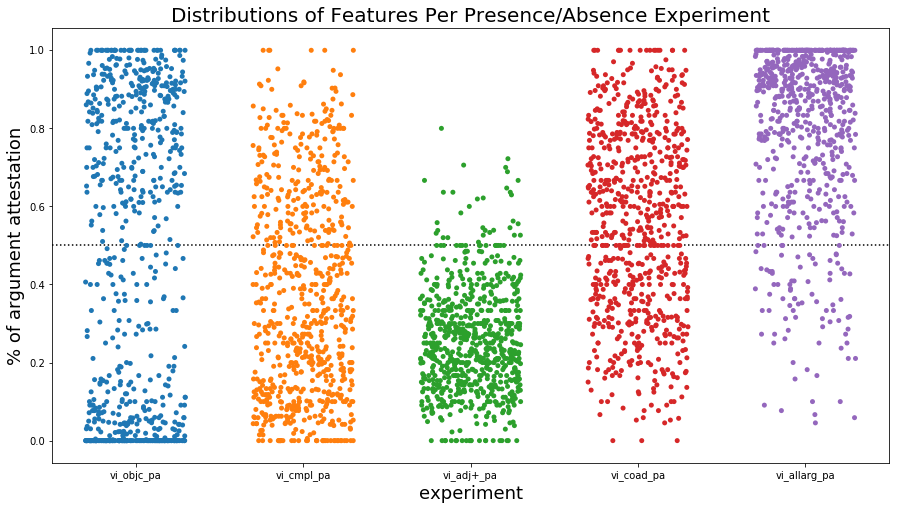

In [99]:
vi_datas = pd.DataFrame(test.loc['Objc'])
vi_datas.columns = ('ratio of attestation',)
vi_datas['experiment'] = 'vi_objc_pa'

vi_datas

for exp_name, experiment in experiments.items():
    
    if exp_name == 'vi_objc_pa' or not re.match('vi_.*_pa', exp_name): # skip any non-pa experiments
        continue
        
    exp = experiment.data / experiment.data.sum()

    arg = next(i for i in exp.index if i != 'ø')
    
    datas = pd.DataFrame(exp.loc[arg])
    datas.columns = ('ratio of attestation',)
    datas['experiment'] = exp_name
    
    vi_datas = pd.concat((vi_datas, datas))

plt.figure(figsize=(15,8))
plt.title('Distributions of Features Per Presence/Absence Experiment', fontsize=20)
sns.stripplot(x='experiment', y='ratio of attestation', data=vi_datas, jitter=0.3)
plt.xlabel('experiment', fontsize=18)
plt.ylabel('% of argument attestation', fontsize=18)
plt.axhline(0.5, color='black', linestyle='dotted')

### Initial Observations

The combined, complement + adjunct experiment seems to have the most even distribution of features. The object presence/absence experiment appears to show the most separation between verbs. The adjunct tends to have <50% attestation, while the opposite is true for the allarg experiment.

It is possible to venture a few generalizations based on this visual:

* Verbs appear to exhibit a more even polarity between the presence/absence of an object argument.
* The number of verbs that occur with or without a complementizer appear to be fairly balanced, with a slight preference for <50% of those verbs' occurrences having a complement.
* There are more verbs with ≤50% of adjunct elements.
* The number of verbs with a higher proportion of complement or adjunct arguments is seems evenly distributed, with a slight preference for >50%.
* The number of verbs with a proportion >50% of any of the arguments appears to be high. 

#### Number of Verbs with 100% or 0% Objc

In [149]:
ratioedO = experiments['vi_objc_pa'].data / experiments['vi_objc_pa'].data.sum()
allO = ratioedO.loc['Objc'][ratioedO.loc['Objc'] == 1.0]
noO = ratioedO.loc['Objc'][ratioedO.loc['ø'] == 1.0]

print(f'{allO.shape[0]} verbs that have an object 100% of the time...')
print(f'{noO.shape[0]} verbs that never occur with an object...')

39 verbs that have an object 100% of the time...
148 verbs that never occur with an object...


#####  Verbs with 100% Objects

In [150]:
print(' | '.join(allO.index))

<WR[.piel | B<T[.piel | BR>[.qal | BXN[.qal | CBH[.qal | CBR[.piel | CLL[.qal | CWB=[.qal | DK>[.piel | FB<[.hif | FMX[.piel | GRC[.piel | JYT[.hif | KN<[.hif | KRH[.qal | LBC[.hif | LXY[.qal | N>Y[.piel | NF>[.piel | NHG[.piel | NPY[.piel | NQB[.qal | NSK[.hif | NTQ[.piel | NXH[.hif | NXH[.qal | NYB[.hif | PQX[.qal | PYH[.qal | RJQ[.hif | RKB[.hif | SQL[.qal | SWT[.hif | XLH[.piel | XLY[.piel | XRB[.hif | YPH=[.piel | ZHR[.hif | ZRH[.piel


##### Verbs with 0% Objects

In [151]:
print(' | '.join(noO.index))

<LH[.nif | <LZ[.qal | <WP[.qal | <YM[.qal | <YR[.nif | >BD[.qal | >BL[.hit | >BL[.qal | >CM[.qal | >ML[.pual | >MY[.qal | >WR[.qal | BHL[.nif | BLH[.qal | BNH[.nif | BQ<[.nif | BRK[.qal | BRX[.qal | BW>[.hof | C<H[.qal | C<N[.nif | C>G[.qal | C>R[.nif | CDD[.pual | CKM[.hif | CKX[.nif | CLK[.hof | CM<[.nif | CMM[.nif | CMR[.nif | CNH[.qal | CPL[.qal | CQD[.qal | CQP[.hif | CRQ[.qal | CW<[.piel | CXX[.qal | DMH=[.nif | FRP[.nif | FXQ[.piel | FXQ[.qal | GBH[.qal | GW<[.qal | HJH[.nif | HLK[.piel | HLL[.hit | HMH[.qal | J<D[.nif | JBC[.qal | JCR[.qal | JD<[.nif | JG<[.qal | JLD[.nif | JLD[.pual | JLL[.hif | JQY[.qal | JR>[.nif | JTR[.nif | JVB[.qal | JXL[.hif | JYB[.hit | KBD[.nif | KBH[.qal | KCL[.nif | KCL[.qal | KLM[.nif | KN<[.nif | KR<[.qal | KTB[.nif | KWN[.nif | KXC[.piel | L<G[.qal | LKD[.nif | MKR[.nif | MLK[.qal | MLV[.nif | MSS[.nif | MWV[.nif | NBL[.qal | NF>[.nif | NGC[.nif | NGD[.hof | NGP[.nif | NPL[.qal | NQH[.nif | NTQ[.nif | NW<[.qal | NWD[.qal | NWX[.qal | NXM[.nif | NY

In [153]:
ratioedO['FMX[.piel']

Objc    1.0
ø       0.0
Name: FMX[.piel, dtype: float64

In [171]:
# B.show(B.search('''

# clause
#     phrase function=Pred
#         word lex=BW>[ vs=qal

#     phrase function=Objc
# '''))

BW> with objects is a good example of the shortcomings of the ETCBC "object" label, which does not sharply distinguish between "objects" and "complements." Note however the group of verbs just beneath the 20% marker in the strip chart. Are many of these motion verbs like BW>?

In [172]:
smallO = ratioedO.loc['Objc'][ratioedO.loc['Objc'] <= 0.20]
print(f'{smallO.shape[0]} verbs that have an object ≤20% of the time...')

289 verbs that have an object ≤20% of the time...


In [173]:
print(' | '.join(smallO.index))

<FH[.nif | <LH[.nif | <LH[.qal | <LZ[.qal | <MD[.qal | <WP[.qal | <WR[.qal | <YM[.qal | <YR[.nif | >BD[.qal | >BH[.qal | >BL[.hit | >BL[.qal | >CM[.qal | >KL[.nif | >ML[.pual | >MN[.hif | >MN[.nif | >MY[.qal | >NX[.nif | >RB[.qal | >SP[.nif | >TH[.qal | >WR[.qal | >XR[.piel | B<R[.qal | BGD[.qal | BHL[.nif | BKH[.qal | BLH[.qal | BLL[.qal | BNH[.nif | BQ<[.nif | BRK[.qal | BRX[.qal | BVX[.qal | BW>[.hof | BW>[.qal | BWC[.qal | BWZ[.qal | C<H[.qal | C<N[.nif | C>G[.qal | C>R[.nif | CB<[.nif | CBR[.nif | CBT[.qal | CDD[.pual | CGH[.qal | CKB[.qal | CKM[.hif | CKN[.qal | CKX[.nif | CLK[.hof | CM<[.nif | CMD[.nif | CMM[.nif | CMM[.qal | CMR[.nif | CNH[.qal | CPL[.qal | CQD[.qal | CQP[.hif | CQV[.qal | CRQ[.qal | CTL[.qal | CW<[.piel | CWB[.qal | CXX[.qal | DBQ[.qal | DMH=[.nif | DMH[.qal | DMM[.qal | FJX[.qal | FMX[.qal | FRP[.nif | FWF[.qal | FXQ[.piel | FXQ[.qal | GBH[.qal | GBR[.qal | GDL[.qal | GJL[.qal | GLH[.nif | GRH[.hit | GW<[.qal | GWR==[.qal | GWR[.qal | HJH[.nif | HJH[.qal | HL

## Looking at Surprise Word Similarities

TO-DO: make a function that spits out a big bar chart with all of the rated similarities per experiment for a given set of words.